# How good is your medium article? -- Predicting from article contents

## Brief introduction

["How good is your medium article?"](https://www.kaggle.com/c/how-good-is-your-medium-article/overview/description) competition on Kaggle. Training set is comprised of articles published before Jul.1, 2017 and testing set consists articles published from Jul.1, 2017 till Mar. 3, 2018. Data is given in JSON format. The goal is to predict number of "claps" in the test set. This target is log1p transformed, log1p(x) = log(1+x). The evaluation metric for this competition is Mean Absolute Error.

I am predicting with 3 different approaches:
- TFIDF: using the importance of words to determine the topic of a document. In this approach, words are giving weights, so this measure is about relevance.
- Bag of Words: basically, it counts how frequent a word appears in a document and use it to .
- Latent Dirichlet Allocation (LDA): extract the distribution of topics as features to predict target.

## 1. Import and prepare data

### 1.1 Take a first look at the training data in terminal
cd /Users/Cheryl/Dropbox/Courses/Open\ ml\ ai/mlcourse.ai-master/data/kaggle_medium

head train.json > 1.json

pip install pyLDAvis

pip install gensim

I am going to explore only the "content" of the data.

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel

/Users/Cheryl/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


### 1.2 Clean and load data
Clean HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Read a JavaScript Object Notation (JSON) line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [4]:
PATH_TO_DATA = '/Users/Cheryl/Dropbox/Courses/Open ml ai/mlcourse.ai-master/data/kaggle_medium'

### 1.3 Preparing content data for NLP models. 

In [5]:
def prep(path_to_inp_json):
    output_list = []
    with open(path_to_inp_json, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [6]:
%%time
train_content = prep(path_to_inp_json=os.path.join(PATH_TO_DATA, 'train.json'),)


CPU times: user 5min 15s, sys: 4.28 s, total: 5min 20s
Wall time: 5min 21s


In [7]:
%%time
test_content = prep(path_to_inp_json=os.path.join(PATH_TO_DATA, 'test.json'),)


CPU times: user 2min 55s, sys: 2.65 s, total: 2min 57s
Wall time: 2min 58s


Just to take a look at the raw data.

In [8]:
print(train_content[0])

Medium Everyone’s stories and ideas Aug 13, 2012 Medium Terms of Service Effective: March 7, 2016 These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using Medium, you agree to these Terms. If you don’t agree to any of the Terms, you can’t use Medium. We can change these Terms at any time. We keep a  historical  record of all changes to our Terms on GitHub. If a change is material, we’ll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don’t agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms. Content rights & responsibilities You own the rights to the content you create and post on Medium. By posting content to Medium, you give us a nonexclusive license to publish it on Medium Services,

### 1.4 Preprocessing

In [9]:
from gensim.parsing.preprocessing import preprocess_documents

In [10]:
%%time
train_content = preprocess_documents(train_content)

CPU times: user 11min 54s, sys: 9.15 s, total: 12min 3s
Wall time: 12min 8s


In [11]:
%%time
test_content = preprocess_documents(test_content)

CPU times: user 6min 20s, sys: 26.3 s, total: 6min 47s
Wall time: 6min 52s


In [12]:
train_content = [' '.join(d) for d in train_content]
test_content = [' '.join(d) for d in test_content]

## 2. TFIDF
### 2.1 Extract features

In [13]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_content)

In [14]:
%%time
X_test = vectorizer.fit_transform(test_content)

CPU times: user 33.2 s, sys: 918 ms, total: 34.2 s
Wall time: 34 s


In [15]:
X_train.shape, X_test.shape

((62313, 10000), (34645, 10000))

In [16]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [17]:
train_target.shape

(62313, 1)

In [18]:
y_train = train_target['log_recommends'].values

### 2.2 Evaluate classifier using holdout method (70% for training and 30% for validating)

In [19]:
train_partition = int(0.7 * X_train.shape[0])
X_train_part = X_train[:train_partition, :]
y_train_part = y_train[:train_partition]
X_valid =  X_train[train_partition:, :]
y_valid = y_train[train_partition:]

In [20]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=2)

In [21]:
%%time
ridge.fit(X_train_part, y_train_part)

CPU times: user 4.47 s, sys: 54.2 ms, total: 4.52 s
Wall time: 4.31 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [22]:
ridge_valid = ridge.predict(X_valid)

Text(0.5, 1.0, 'Classifier validation on training data')

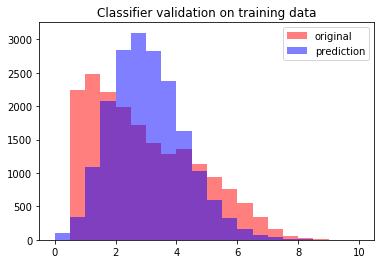

In [23]:
plt.hist(y_valid, bins=20, alpha=.5, color='red', label='original', range=(0,10))
plt.hist(ridge_valid, bins=20, alpha=.5, color='blue', label='prediction', range=(0,10))
plt.legend()
plt.title('Classifier validation on training data')

Caculate MAE for training data set, recall that our target (number of claps) is log1p transformed.

In [24]:
mae_valid = mean_absolute_error(y_valid, ridge_valid)
mae_valid, np.expm1(mae_valid)

(1.240642663244433, 2.4578349742882457)

The prediction for validation is not perfect, but somewhat acceptable. On average, this model yields approximately 2.5 errors in predicting the number of claps. Next, I look at how it works for predicting the testing dataset.

### 2.3 Fit a ridge model

In [25]:
%%time
ridge.fit(X_train, y_train)

CPU times: user 6.7 s, sys: 152 ms, total: 6.85 s
Wall time: 6.56 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [26]:
%%time
ridge_pred = ridge.predict(X_test)

CPU times: user 27.9 ms, sys: 2 ms, total: 29.9 ms
Wall time: 27.7 ms


In [27]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [28]:
write_submission_file(prediction=ridge_pred, filename='TFIDF_ridge.csv')

**Kaggle gives this submission with MAE approximately 2.23, so this model yields about 2.23 errors in prediction.**

## 3. BoW
### 3.1 Feature extraction

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
BoW = CountVectorizer(max_features=10000)

In [31]:
%%time
X_train_BoW = BoW.fit_transform(train_content)

CPU times: user 1min 1s, sys: 1.42 s, total: 1min 3s
Wall time: 1min 3s


In [32]:
%%time
X_test_BoW = BoW.fit_transform(test_content)

CPU times: user 33.5 s, sys: 1.38 s, total: 34.9 s
Wall time: 35.3 s


### 3.2 Classifier validation

In [33]:
train_BoW_partition = int(0.7 * X_train_BoW.shape[0])
X_train_BoW_part = X_train_BoW[:train_BoW_partition, :]
y_train_BoW_part = y_train[:train_BoW_partition]
X_valid_BoW =  X_train_BoW[train_BoW_partition:, :]
y_valid_BoW = y_train[train_BoW_partition:]

In [34]:
ridge_BoW = Ridge(random_state=2)

In [35]:
%%time
ridge_BoW.fit(X_train_BoW_part, y_train_BoW_part)

CPU times: user 1min 8s, sys: 870 ms, total: 1min 8s
Wall time: 1min 11s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [36]:
ridge_valid_BoW = ridge_BoW.predict(X_valid_BoW)

Text(0.5, 1.0, 'BoW classifier validation on training data')

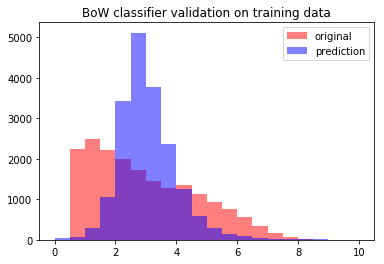

In [37]:
plt.hist(y_valid_BoW, bins=20, alpha=.5, color='red', label='original', range=(0,10))
plt.hist(ridge_valid_BoW, bins=20, alpha=.5, color='blue', label='prediction', range=(0,10))
plt.legend()
plt.title('BoW classifier validation on training data')

In [38]:
mae_valid_BoW = mean_absolute_error(y_valid_BoW, ridge_valid_BoW)
mae_valid_BoW, np.expm1(mae_valid_BoW)

(1.2984609201574706, 2.6636536707071623)

### 2.3 Model fitting

In [39]:
%%time
ridge_BoW.fit(X_train_BoW, y_train)

CPU times: user 2min 56s, sys: 1.16 s, total: 2min 57s
Wall time: 2min 57s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [40]:
%%time
ridge_pred_BoW = ridge_BoW.predict(X_test_BoW)

CPU times: user 75.3 ms, sys: 227 ms, total: 302 ms
Wall time: 299 ms


In [41]:
write_submission_file(prediction=ridge_pred_BoW, filename='BoW.csv')

**Score 2.04**

## 4. LDA

note: It took me so long to build the bigram and trigram models, so I will just work with unigram as I have extracted earlier.
> %%time <br>
> bigram = gensim.models.Phrases(train_content, min_count=5, threshold=100)<br>
> trigram = gensim.models.Phrases(bigram[train_content], threshold=100)<br>
> bigram_mod = gensim.models.phrases.Phraser(bigram)<br>
> trigram_mod = gensim.models.phrases.Phraser(trigram)

### 4.1 Build corpus and dictionary.

In [379]:
# Stack sparse matrix from test and train from BoW (to get the entire dataset). 
from scipy import sparse
full_sparse_data = sparse.vstack([X_train_BoW, X_test_BoW])

In [380]:
# Transform data to gensim corpus.
gensim_corpus_data = gensim.matutils.Sparse2Corpus(full_sparse_data, documents_columns=False)

In [381]:
# Create Dictionary for the entire dataset (both training and testing).
vocabulary_gensim = {}
for key, val in BoW.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dictionary = Dictionary()
dictionary.merge_with(vocabulary_gensim)

### 4.2 Build LDA model and visualize the topics.
note: I just assumed 20 topics, but the optimal number of topics can be determined through comparing coherence score among different models.
I also did a quick detour on the number of topics late.

In [382]:
%%time
lda = LdaModel(gensim_corpus_data, num_topics = 20)

CPU times: user 8min 27s, sys: 57.2 s, total: 9min 24s
Wall time: 5min 9s


In [383]:
import pyLDAvis.gensim
lda_data = pyLDAvis.gensim.prepare(lda, gensim_corpus_data, dictionary)

In [384]:
# Visualize the topics in the entire dataset
pyLDAvis.display(lda_data)

Each bubble on the left represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart. <br/>
Note that I still have many bubbles overlapped in quardrant II, so I am going to reduce the number of topics next.

In [385]:
# Build LDA model for the training and testing data seperately, then I will extract features in the next step
gensim_corpus_train = gensim.matutils.Sparse2Corpus(X_train_BoW, documents_columns=False)
lda_train = LdaModel(gensim_corpus_train, num_topics = 20)
gensim_corpus_test = gensim.matutils.Sparse2Corpus(X_test_BoW, documents_columns=False)
lda_test = LdaModel(gensim_corpus_test, num_topics = 20)

In [386]:
# Visualize topics only in the training set
lda_data_train = pyLDAvis.gensim.prepare(lda_train, gensim_corpus_train, dictionary)
pyLDAvis.display(lda_data_train)

### _Quick detour 1 : LDA model with fewer number of topics_

In [387]:
lda_train_fewertopics = LdaModel(gensim_corpus_train, num_topics = 15)
lda_data_train_fewertopics =  pyLDAvis.gensim.prepare(lda_train_fewertopics, gensim_corpus_train, dictionary)
pyLDAvis.display(lda_data_train_fewertopics)

Now this seems better. For confirmation, I will calculate  perplexity for each of them.

In [388]:
from gensim.models import CoherenceModel

In [389]:
# Compute Perplexity
print('\nPerplexity: ', lda_train.log_perplexity(gensim_corpus_train))  # a measure of how good the model is. lower the better.


Perplexity:  -7.37260383832435


In [390]:
print('\nPerplexity: ', lda_train_fewertopics.log_perplexity(gensim_corpus_train))


Perplexity:  -7.4155431850411215


According to the perplexity score, my original training model is better. I am going to use this one for feature extraction.

### 4.3 Feature extraction
#### Feature extraction for raining data

In [391]:
topic_weights_train = lda_train.get_document_topics(gensim_corpus_train, minimum_probability=0)

In [392]:
topic_weights_train = np.array(topic_weights_train)

In [393]:
topic_weights_train.shape

(62313, 20, 2)

In [394]:
lda_features_data_train = pd.DataFrame(topic_weights_train[:,:,1])

In [395]:
lda_features_data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.098161,0.000091,0.000091,0.017999,0.000091,0.000091,0.035142,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.247322,0.000091,0.000091,0.400210,0.199888,0.000091
1,0.103268,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.063563,0.486041,0.000059,0.000059,0.248901,0.097336,0.000059
2,0.196217,0.001429,0.001429,0.108773,0.001429,0.056276,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.099368,0.131837,0.001429,0.001429,0.215738,0.001429,0.173215


In [396]:
lda_features_data_train['target'] = y_train

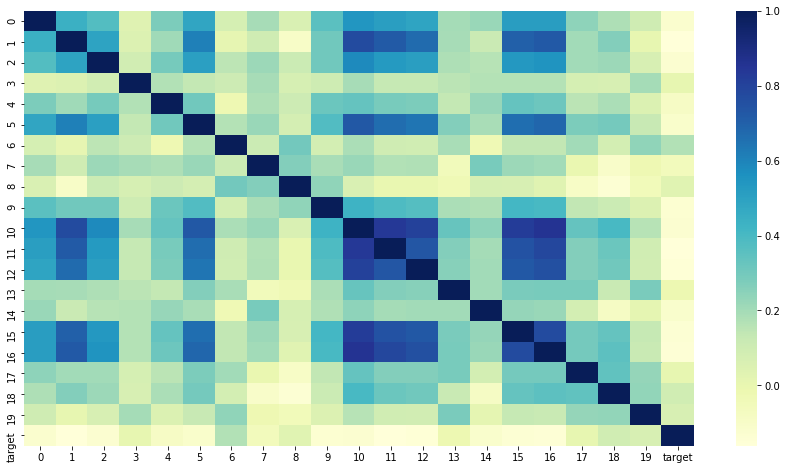

In [397]:
# How are the features correlate with the target?
fig, ax = plt.subplots(figsize=(15,8))
heatmap = sns.heatmap(lda_features_data_train.corr(method='spearman'), cmap='YlGnBu')

In [398]:
lda_features_data_train = lda_features_data.drop('target', axis = 1)

#### Feature extraction for testing data

In [399]:
topic_weights_test = lda_test.get_document_topics(gensim_corpus_test, minimum_probability=0)

In [400]:
topic_weights_test = np.array(topic_weights_test)

In [401]:
lda_features_data_test = pd.DataFrame(topic_weights_test[:,:,1])

### 4.4 Fit model

In [405]:
X_lda_train = sparse.hstack([X_train_BoW, lda_features_data_train]).tocsr()

In [406]:
X_lda_test = sparse.hstack([X_test_BoW, lda_features_data_test]).tocsr()

In [407]:
ridge_lda = Ridge(random_state=2)

In [408]:
%%time
ridge_lda.fit(X_lda_train, y_train)

CPU times: user 2min 59s, sys: 612 ms, total: 2min 59s
Wall time: 2min 59s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [409]:
ridge_pred_lda = ridge_lda.predict(X_lda_test)

In [410]:
write_submission_file(prediction=ridge_pred_lda, filename='lda.csv')

**Score 2.04**

### _Quick detour 2: leaderboard probing_
1. Make zero submissions and get testing MAE
2. Compare it with our target mean and adjust predictions accordingly

In [429]:
mean_test_target = 4.33328

In [430]:
pred_modif = ridge_pred_lda + mean_test_target - y_train.mean()

In [431]:
write_submission_file(prediction=pred_modif, filename='probing.csv')

**Score 1.83**

## lightGBM